<a href="https://colab.research.google.com/github/strangelycutlemon/DS-Unit-1-Sprint-4-Linear-Algebra/blob/master/module3-dimensionality-reduction/High_Dimensional_Data_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vertical Line Test

## 1.1 Create two graphs, one that passes the vertical line test and one that does not.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
a = np.array([[1,1],[2,3],[3,4],[4,7],[5,2]])
b = np.array([[1,1],[1,2],[2,3],[2,5],[4,5]])

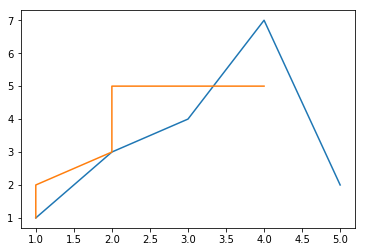

In [3]:
fig = plt.figure()
plt.plot(a[:,0], a[:,1])
plt.plot(b[:,0], b[:,1])
plt.show()

## 1.2 Why are graphs that don't pass the vertical line test not considered "functions?"

They are not injective. In other words, they do not map every element in their domains to a distinct element in their codomains.

# Functions as Relations

## 2.1 Which of the following relations are functions? Why?

\begin{align}
\text{Relation 1: } \{(1, 2), (3, 2), (1, 3)\}
\\
\text{Relation 2: } \{(1, 3), (2, 3), (6, 7)\}
\\
\text{Relation 3: } \{(9, 4), (2, 1), (9, 6)\}
\\
\text{Relation 4: } \{(6, 2), (8, 3), (6, 4)\}
\\
\text{Relation 5: } \{(2, 6), (2, 7), (2, 4)\}
\end{align}

Relation 2 is the only function, because all the others map one of their inputs to different outputs.

# Functions as a mapping between dimensions


## 3.1 for the following functions what is the dimensionality of the domain (input) and codomain (range/output)?

\begin{align}
m(𝑥_1,𝑥_2,𝑥_3)=(x_1+x_2, x_1+x_3, x_2+x_3)
\\
n(𝑥_1,𝑥_2,𝑥_3,𝑥_4)=(x_2^2 + x_3, x_2x_4)
\end{align}

M maps R^3 to itself.
N maps R^4 to R^2. 

## 3.2 Do you think it's possible to create a function that maps from a lower dimensional space to a higher dimensional space? If so, provide an example.

\begin{align}
m(𝑥_1)=(𝑥_1,𝑥_1,𝑥_1)
\end{align}

# Vector Transformations

## 4.1 Plug the corresponding unit vectors into each function. Use the output vectors to create a transformation matrix.

\begin{align}
p(\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}) = \begin{bmatrix} x_1 + 3x_2 \\2 x_2 - x_1 \\  \end{bmatrix}
\\
\\
q(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}) = \begin{bmatrix} 4x_1 + x_2 + 2x_3 \\2 x_2 - x_1 + 3x_3 \\ 5x_1 - 2x_3 + x_2  \end{bmatrix}
\end{align}

\begin{align}
p(\begin{bmatrix} 1 \\ 0 \end{bmatrix}) = \begin{bmatrix} 1 \\ -1 \end{bmatrix}
\\
p(\begin{bmatrix} 0 \\ 1 \end{bmatrix}) = \begin{bmatrix} 3 \\ 2 \end{bmatrix}
\end{align}

\begin{bmatrix} 1 & 3 \\ -1 & 2 \end{bmatrix}
\
\
\begin{align}
q(\begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix}) = \begin{bmatrix} 4 \\ -1 \\ 5 \end{bmatrix}
\\
q(\begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix}) = \begin{bmatrix} 1 \\ 2 \\ 1 \end{bmatrix}
\\
q(\begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}) = \begin{bmatrix} 2 \\ 3 \\ -2 \end{bmatrix}
\end{align}


\begin{bmatrix} 4 & 1 & 2 \\ -1 & 2 & 3 \\ 5 & 1 & -2\end{bmatrix}

## 4.2 Verify that your transformation matrices are correct by choosing an input matrix and calculating the result both via the traditional functions above and also via vector-matrix multiplication.

In [4]:
M_p = np.array([[1,3],[-1,2]])
def p(x1, x2):
  return np.array([x1+(3*x2), (2*x2)-x1])

c = np.array([3, 4])

print(np.dot(M_p, c))
print(p(c[0],c[1]))

[15  5]
[15  5]


# Eigenvalues and Eigenvectors

## 5.1 In your own words, give an explanation for the intuition behind eigenvalues and eigenvectors.

Eigenvectors are the vectors that are simply scaled when a linear transformation is applied to them. The number of eigenvectors of a linear transformation is equal to or less than the dimension of the linear transformation's co-domain.

Each eigenvector has an eigenvalue, which is the value by which it is scaled when the transformation is applied.

# The Curse of Dimensionality

## 6.1 What are some of the challenges of working with high dimensional spaces?

1. The computational complexity of a transformation on a matrix is exponential in the number of dimensions of that matrix. computing on high-dimenional matrices can be computationally intractable.

2. If you have a low number of observations and a high number of dimensions(features), you are liable to overfit your model.


## 6.2 What is the rule of thumb for how many observations you should have compared to parameters in your model?

No fewer than 5 observations for each parameter.

# Principal Component Analysis

## 7.1 Load the UCI Machine Learning Repository's [Iris Dataset](https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv) and use PCA to isolate the dataset's first and second principal components and plot them on a graph. 

In [5]:
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv'
df = pd.read_csv(url)

df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [0]:
X = df.loc[:,'sepal_length':'petal_width']

In [7]:
X_centered = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X_centered.head()

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


In [0]:
zmatrix = np.cov(X_centered.T)

In [9]:
varcovar = np.dot(zmatrix.T, zmatrix)
values, vectors = np.linalg.eig(varcovar)
values

array([8.58697325e+00, 8.60077477e-01, 2.20054162e-02, 4.30397097e-04])

In [10]:
vectors

array([[ 0.52237162, -0.37231836, -0.72101681,  0.26199559],
       [-0.26335492, -0.92555649,  0.24203288, -0.12413481],
       [ 0.58125401, -0.02109478,  0.14089226, -0.80115427],
       [ 0.56561105, -0.06541577,  0.6338014 ,  0.52354627]])

In [0]:
P = vectors.T.dot(X_centered.T)
X = P.T[:,0]
Y = P.T[:,1]

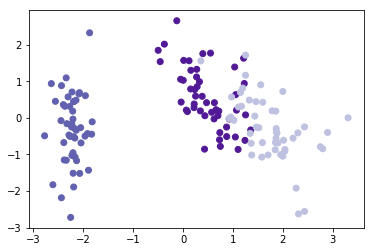

In [19]:
colors = {'setosa':'#6161AF', 'virginica':'#BFC1E1', 'versicolor':'#511996'}

plt.scatter(X,Y, c=df.species.apply(lambda x: colors[x]));

## Everything below this is garbage.


In [0]:
means = np.mean(df2, axis=0).values
centered_df2 = df2 - means
# cov_df2 = np.cov(centered_df2)
stdv = np.std(centered_df2, axis=0).values
# values, vectors = np.linalg.eig(cov_df2)

In [123]:
stdv

array([0.82530129, 0.43214658, 1.75852918, 0.76061262])

In [0]:
centered_df2 = centered_df2 / stdv
# cov_df2 = np.dot(centered_df2.T, centered_df2)
centered_df2 = np.cov(centered_df2.T)
varcovar = np.matmul(centered_df2.T, centered_df2)
values, vectors = np.linalg.eig(cov_df2)

In [125]:
vectors

array([[ 0.52237162, -0.37231836, -0.72101681,  0.26199559],
       [-0.26335492, -0.92555649,  0.24203288, -0.12413481],
       [ 0.58125401, -0.02109478,  0.14089226, -0.80115427],
       [ 0.56561105, -0.06541577,  0.6338014 ,  0.52354627]])

In [126]:
cov_df2

array([[150.        , -16.40538749, 130.7631236 , 122.69304501],
       [-16.40538749, 150.        , -63.07741446, -53.48161344],
       [130.7631236 , -63.07741446, 150.        , 144.41356456],
       [122.69304501, -53.48161344, 144.41356456, 150.        ]])

In [128]:
cov_df2

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977
5,-0.537178,1.957669,-1.170675,-1.050031
6,-1.506521,0.800654,-1.341272,-1.181504
7,-1.021849,0.800654,-1.284407,-1.312977
8,-1.748856,-0.356361,-1.341272,-1.312977
9,-1.143017,0.106445,-1.284407,-1.444450


In [118]:
P = vectors.T.dot(centered_df2)

ValueError: ignored

P

In [104]:
P.real.T.shape

(4, 150)

In [108]:
P.real

array([[ 8.02940453e+00, -3.13597129e+00,  2.11065448e+01,
         8.69854805e+00],
       [-5.17592067e+00, -1.45169333e+00, -1.64907373e+00,
         6.74204046e-01],
       [ 4.96441642e-01,  2.32604458e+00,  2.23554695e+00,
         7.54382840e-03],
       [-4.82220321e-02, -4.82220321e-02, -4.82220321e-02,
        -4.82220321e-02],
       [-4.82220321e-02, -4.82220321e-02, -4.82220321e-02,
        -4.82220321e-02],
       [-8.78972428e-02, -8.78972428e-02, -8.78972428e-02,
        -8.78972428e-02],
       [ 2.48592169e-01,  2.48592169e-01,  2.48592169e-01,
         2.48592169e-01],
       [ 2.48592169e-01,  2.48592169e-01,  2.48592169e-01,
         2.48592169e-01],
       [-1.91912344e-01, -1.91912344e-01, -1.91912344e-01,
        -1.91912344e-01],
       [-1.91912344e-01, -1.91912344e-01, -1.91912344e-01,
        -1.91912344e-01],
       [ 5.97995910e-03,  5.97995910e-03,  5.97995910e-03,
         5.97995910e-03],
       [ 5.97995910e-03,  5.97995910e-03,  5.97995910e-03,
      

In [0]:
X = P.real.T[:,0]
Y = P.real.T[:,1]

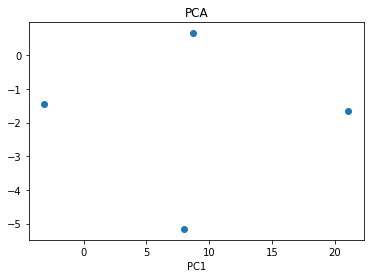

In [106]:
plt.scatter(X, Y)
plt.title("PCA")
plt.xlabel('PC1')
plt.show()

In [68]:
df3 = df3.replace({'setosa':1, 'versicolor':2, 'virginica':3})
df3.head()

0    1
1    1
2    1
3    1
4    1
Name: species, dtype: int64

In [69]:
np.cov(df2.T, df3)

array([[ 0.68569351, -0.03926846,  1.27368233,  0.5169038 ,  0.53087248],
       [-0.03926846,  0.18800403, -0.32171275, -0.11798121, -0.14899329],
       [ 1.27368233, -0.32171275,  3.11317942,  1.29638747,  1.37181208],
       [ 0.5169038 , -0.11798121,  1.29638747,  0.58241432,  0.59798658],
       [ 0.53087248, -0.14899329,  1.37181208,  0.59798658,  0.67114094]])

In [73]:
P

array([[ 8.02940453e+00+0.j        , -3.13597129e+00+0.j        ,
         2.11065448e+01+0.j        ,  8.69854805e+00+0.j        ],
       [-5.17592067e+00+0.j        , -1.45169333e+00+0.j        ,
        -1.64907373e+00+0.j        ,  6.74204046e-01+0.j        ],
       [ 4.96441642e-01+0.j        ,  2.32604458e+00+0.j        ,
         2.23554695e+00+0.j        ,  7.54382840e-03+0.j        ],
       [-4.82220321e-02+0.02554287j, -4.82220321e-02+0.02554287j,
        -4.82220321e-02+0.02554287j, -4.82220321e-02+0.02554287j],
       [-4.82220321e-02-0.02554287j, -4.82220321e-02-0.02554287j,
        -4.82220321e-02-0.02554287j, -4.82220321e-02-0.02554287j],
       [-8.78972428e-02+0.j        , -8.78972428e-02+0.j        ,
        -8.78972428e-02+0.j        , -8.78972428e-02+0.j        ],
       [ 2.48592169e-01+0.10452135j,  2.48592169e-01+0.10452135j,
         2.48592169e-01+0.10452135j,  2.48592169e-01+0.10452135j],
       [ 2.48592169e-01-0.10452135j,  2.48592169e-01-0.10452135j,
   

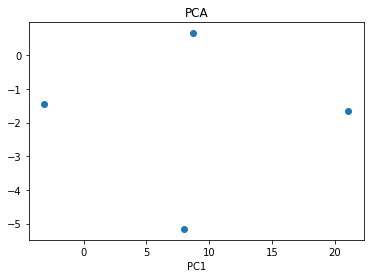

In [75]:
plt.scatter(P[0].real, P[1].real, color=)
plt.title("PCA")
plt.xlabel('PC1')
plt.show()

# Stretch Goal

## 1) Do NOT work on the stretch goal until you feel like you have a firm grasp of eigenvectors, eigenvalues, and PCA. Prioritize self-study over the stretch goal if you are not comfortable with those topics yet.

## 2) Explore further the intuition behind eigenvalues and eigenvectors by creating your very own eigenfaces:

<center>![Eigenfaces](https://i.pinimg.com/236x/1c/f1/01/1cf101a9859437a5d096a04b05be06b4--faces-tattoo.jpg)</center>

You don't necessarily have to use this resource, but this will get you started: 
[Eigenface Tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)